In [185]:
import pandas
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [359]:
from mlflow import MlflowClient
import mlflow
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from collections import defaultdict
import scienceplots
from sklearn import datasets
from sklearn.datasets import make_blobs
from cycler import cycler
plt.style.use(['science', 'bright'])


In [187]:
client = MlflowClient(tracking_uri="http://192.168.1.181:5010")
mlflow.set_tracking_uri("http://192.168.1.181:5010")


In [188]:
complexities_df = pd.read_csv('complexities.csv')\
    .rename(columns={"shuffle": "params.data_shuffle_random_state", "dataset_name": "params.dataset", "should_take_test": "params.should_take_test"})\
    .astype({"params.data_shuffle_random_state": str, "params.should_take_test": str, "params.dataset": str})

In [189]:
COMPLEXITY_METRICS = [m for m in complexities_df.columns.tolist()[3:] if 'time' not in m]

In [190]:
def get_runs_for(name, client = client):
    return mlflow.search_runs(client.get_experiment_by_name(name).experiment_id)

In [191]:
CLASSIFICATION_METRICS = ['metrics.tn', 'metrics.tp', 'metrics.fp', 'metrics.fn']
DATASET_PARAMS = ['params.should_take_test', 'params.dataset', 'params.data_shuffle_random_state']
RF_METRICS = ['metrics.depth_mean',
              'metrics.depth_min',
              'metrics.depth_median',
              'metrics.n_leaves_max',
              'metrics.n_leaves_min',
              'metrics.n_leaves_mean',
              'metrics.depth_max',
              'metrics.n_leaves_median',]
OPTIMAL_CENTROID_PARAMS = ['params.subspaces', 'metrics.should_take_tree']

In [192]:
def calculate_accuracy(row):
    return (row['metrics.tp'] + row['metrics.tn']) / (row['metrics.fp'] + row['metrics.tp'] + row['metrics.tn'] + row['metrics.fn'])

In [193]:
def calculate_recall(row):
    return row['metrics.tp'] / (row['metrics.tp'] + row['metrics.fn'])

def calculate_precision(row):
    return row['metrics.tp'] / (row['metrics.tp'] + row['metrics.fp'])

In [194]:
base_runs_dt = get_runs_for("base_runs_dt")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.depth', "metrics.n_leaves"]]\
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall)\
    .assign(test_precision=calculate_precision)

In [195]:
base_runs_rf = get_runs_for("base_runs_rf")[CLASSIFICATION_METRICS + DATASET_PARAMS + RF_METRICS]\
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [196]:
base_runs_oner = (get_runs_for("base_runs_oner")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.rules_no', 'metrics.depth']]

    .assign(test_accuracy=calculate_accuracy)) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)


In [197]:
base_runs_rulefit = (get_runs_for("base_runs_rulefit")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.max_rules', 'metrics.rules_no', 'metrics.terms_no']]
    .assign(test_accuracy=calculate_accuracy)) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)


In [198]:
base_runs_greedy = (get_runs_for("base_runs_greedy")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.depth', 'metrics.rules_no']]
        .assign(test_accuracy=calculate_accuracy))\
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [199]:
optimal_centroid_runs_df =get_runs_for("07.05-optimal-centroids")[CLASSIFICATION_METRICS + DATASET_PARAMS + RF_METRICS + OPTIMAL_CENTROID_PARAMS] \
    .assign(test_accuracy=calculate_accuracy)

In [200]:
optimal_centroid_runs_df =get_runs_for("07.08-optimal-centroids-no-depth")[CLASSIFICATION_METRICS + DATASET_PARAMS + RF_METRICS + OPTIMAL_CENTROID_PARAMS] \
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [201]:
base_runs_rf.rename(columns={c: c+'_rf' for c in base_runs_rf.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_dt.rename(columns={c: c+'_dt' for c in base_runs_dt.columns if 'metric' in c  or 'test_' in c}, inplace=True)
base_runs_greedy.rename(columns={c: c+'_greedy' for c in base_runs_greedy.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_oner.rename(columns={c: c+'_oner' for c in base_runs_oner.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_rulefit.rename(columns={c: c+'_rulefit' for c in base_runs_rulefit.columns if 'metric' in c or 'test_' in c}, inplace=True)


In [202]:
base_runs_together_df = pd.merge(
    base_runs_dt,
    base_runs_rf,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('_dt', '_rf')
)\
    .merge(base_runs_greedy, how='right', on=DATASET_PARAMS, suffixes=('', '_greedy'))\
    .merge(base_runs_oner, how='right', on=DATASET_PARAMS, suffixes=('', '_oner'))\
    .merge(base_runs_rulefit, how='right', on=DATASET_PARAMS, suffixes=('', '_rulefit'))\
    .dropna()
optimal_centroids_df = pd.merge(
    base_runs_together_df,
    optimal_centroid_runs_df,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('', '_opt')
)
optimal_centroids_df = pd.merge(
    optimal_centroids_df,
    complexities_df,
    how='left',
    on=DATASET_PARAMS
)

In [203]:
[c for c in base_runs_together_df.columns if "accuracy" in c]

['test_accuracy_dt',
 'test_accuracy_rf',
 'test_accuracy_greedy',
 'test_accuracy_oner',
 'test_accuracy_rulefit']

In [204]:
optimal_centroids_df.dropna(inplace=True)

In [244]:
optimal_centroids_df['test_accuracy'] = optimal_centroids_df.apply(lambda row: row['test_accuracy_dt'] if row['metrics.should_take_tree'] == True else row['test_accuracy'], axis=1)

In [357]:
optimal_centroids_df['metrics.should_take_tree'] == True

0       True
1      False
2       True
3       True
4      False
       ...  
955    False
956    False
957    False
958    False
959    False
Name: metrics.should_take_tree, Length: 846, dtype: bool

In [353]:
optimal_centroids_df.apply(lambda row: row['test_accuracy_dt'] if row['metrics.should_take_tree'] == True else row['test_accuracy'], axis=1)

0      0.865443
1      0.755352
2      0.865443
3      0.865443
4      0.807339
         ...   
955    0.917889
956    0.912023
957    0.906158
958    0.912023
959    0.929619
Length: 846, dtype: float64

In [245]:
optimal_centroids_df.groupby('params.subspaces')['test_accuracy'].mean()

params.subspaces
10    0.778822
15    0.772157
20    0.772291
3     0.795629
30    0.769423
5     0.785160
Name: test_accuracy, dtype: float64

In [246]:
optimal_centroids_df.dropna(inplace=True)

In [257]:
METRICS = ['test_accuracy', 'test_recall', 'test_precision']

In [247]:
SUFFIXES = ["_dt", "_rf", "_oner", "_rulefit", "_greedy"]

In [369]:
def define_comparison(row, suffix, metric):
    if row[f'{metric}_equal{suffix}']:
        return "equal"
    if row[f'{metric}_better{suffix}']:
        return "better"
    else:
        return "worse"

In [370]:
for suffix in SUFFIXES:
    for metric in METRICS:
        optimal_centroids_df[f'{metric}_diff_to{suffix}'] = optimal_centroids_df[metric] - optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_better_equal{suffix}'] = optimal_centroids_df[metric] >= optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_better{suffix}'] = optimal_centroids_df[metric] > optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_worse{suffix}'] = ~optimal_centroids_df[f'{metric}_better_equal{suffix}']
        optimal_centroids_df[f'{metric}_worse_equal{suffix}'] = ~optimal_centroids_df[f'{metric}_better{suffix}']
        optimal_centroids_df[f'{metric}_equal{suffix}'] = optimal_centroids_df[metric] == optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_comparison{suffix}'] = optimal_centroids_df.apply(lambda row: define_comparison(row, suffix, metric), axis=1)

In [252]:
optimal_centroids_df['complexity_rf'] = optimal_centroids_df['metrics.depth_median_rf'] * 32 *optimal_centroids_df['metrics.n_leaves_median_rf']
optimal_centroids_df['complexity'] = optimal_centroids_df['metrics.depth_median'] * optimal_centroids_df['params.subspaces'].astype(int) * optimal_centroids_df['metrics.n_leaves_median']
optimal_centroids_df['complexity_dt'] = optimal_centroids_df['metrics.depth_dt'] * optimal_centroids_df['metrics.n_leaves_dt']
optimal_centroids_df['complexity_rulefit'] = optimal_centroids_df['metrics.rules_no_rulefit']
optimal_centroids_df['complexity_oner'] = optimal_centroids_df['metrics.rules_no_oner']


# COMPARISON TO ALGORITHSM

In [256]:
LIMITING_QUERY = "`params.subspaces` == '3'"

In [255]:
COMPARED_ALGS = ['rf', 'dt']

In [287]:
optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .pivot_table(columns=['comparison_rulefit'], aggfunc="count", values=["test_accuracy"])

comparison_rulefit,better,equal,worse
test_accuracy,44,21,76


In [367]:
optimal_centroids_df[['test_accuracy', 'test_precision']]

,test_accuracy,test_precision
0,0.865443,0.966216
1,0.755352,0.689189
2,0.865443,0.966216
3,0.865443,0.966216
4,0.807339,0.695946
...,...,...
955,0.917889,0.873950
956,0.912023,0.890756
957,0.906158,0.890756
958,0.912023,0.907563


In [344]:
def vals_to_percentage(l):
    total = sum(l)
    
    return [round(item/total*100,2) for item in l]
    

## WINS-LOSSES acc general

In [379]:
def plot_bar(labels, values_dict, quants):
    plot_labels = [l.split('_')[-1].upper() for l in labels]
    data = np.array(list(values_dict.values()))
    data_cum = data.cumsum(axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    for i, colname in enumerate(quants):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
    
    
        ax.bar_label(rects, label_type='center')
    
    
    ax.legend(ncols=len(plot_labels), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')


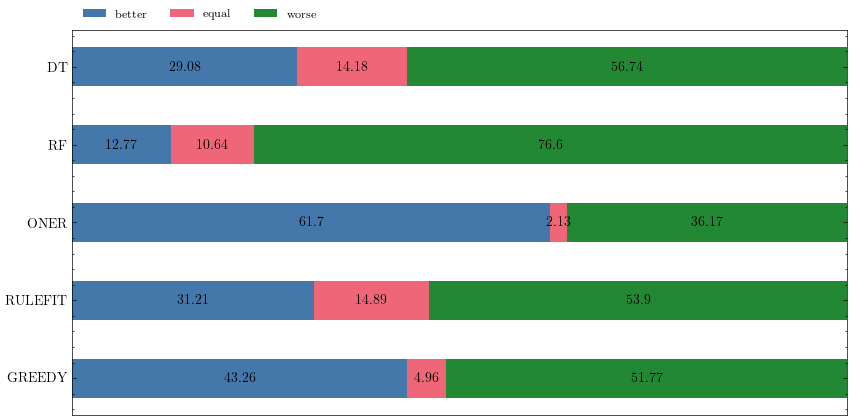

In [385]:
labels = [f"test_accuracy_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}
vals_to_plot
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'])

## WINS-LOSSES recall general

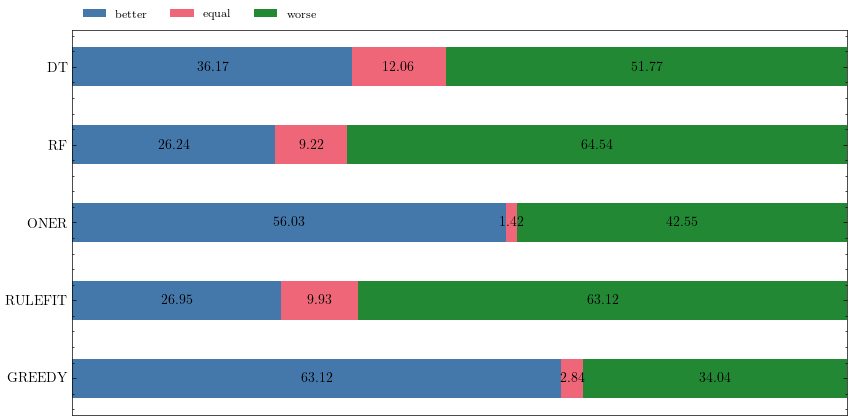

In [387]:
labels = [f"test_recall_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'])


## WINS-LOSSES precision general

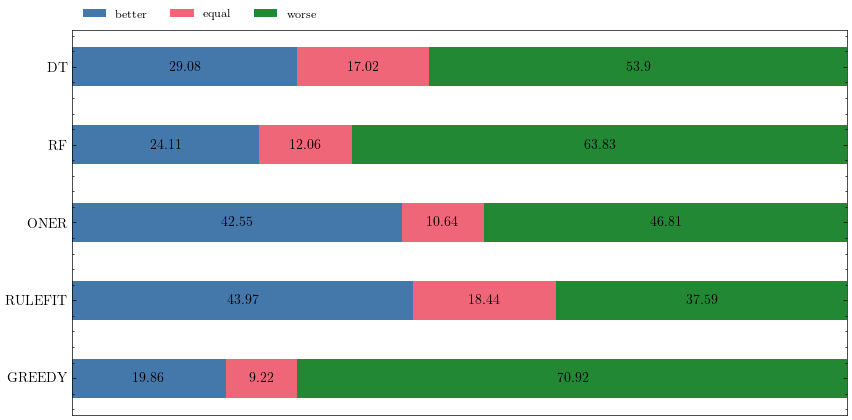

In [388]:
labels = [f"test_precision_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'])

## WINS-LOSSES per complexity


In [389]:
values_to_plot = defaultdict(dict)

In [ ]:
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}


In [407]:
ACC_LABELS = [f"test_accuracy_comparison{suffix}" for suffix in SUFFIXES]


In [411]:
vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in
                    
                    optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .query("`n1-discretized` == 'low'")[ACC_LABELS].apply(pd.Series.value_counts).fillna(0).to_dict().items()}
vals_to_plot

{'test_accuracy_comparison_dt': [35.42, 20.83, 43.75],
 'test_accuracy_comparison_rf': [14.58, 25.0, 60.42],
 'test_accuracy_comparison_oner': [75.0, 0.0, 25.0],
 'test_accuracy_comparison_rulefit': [18.75, 29.17, 52.08],
 'test_accuracy_comparison_greedy': [66.67, 2.08, 31.25]}

In [ ]:
optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()

In [421]:
COMPLEXITIES_TO_CONSIDER = ['f2', 't4', 'c1', 'n3', 'l2', 'density']

In [ ]:
optimal_centroids_df.query(LIMITING_QUERY)

In [ ]:
fig, axes = plt.subplots(len(COMPLEXITIES_TO_CONSIDER),3, sharey=True, figsize=(20, 20))

axes = axes.reshape(-1)

axes_iter = iter(axes)
for complexity in COMPLEXITIES_TO_CONSIDER:
    plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]
    
    
    for value in ['low', 'medium', 'high']:

        ax = next(axes_iter)
        vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY).query(f"`{complexity}-discretized` == '{value}'")[ACC_LABELS].apply(pd.Series.value_counts).fillna(0).to_dict().items()}

        data = np.array(list(vals_to_plot.values()))
        data_cum = data.cumsum(axis=1)
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())
    
        for i, colname in enumerate(['better', 'equal', 'worse']):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
            ax.bar_label(rects, label_type='center')
    
        ax.set_title(f"{complexity}-{value}")
       
ax.legend(ncols=len(plot_labels), bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='small')


In [366]:
optimal_centroids_df.query(LIMITING_QUERY)

,metrics.tn_dt,metrics.tp_dt,metrics.fp_dt,metrics.fn_dt,params.should_take_test,params.dataset,params.data_shuffle_random_state,metrics.depth_dt,metrics.n_leaves_dt,test_accuracy_dt,...,equal_dt,equal_rf,equal_oner,equal_rulefit,equal_greedy,comparison_dt,comparison_rf,comparison_oner,comparison_rulefit,comparison_greedy
5,140.0,143.0,5.0,39.0,False,crx,99,2.0,3.0,0.865443,...,True,False,False,False,True,equal,worse,better,better,equal
11,146.0,135.0,13.0,32.0,True,crx,99,2.0,3.0,0.861963,...,False,False,False,False,False,worse,better,better,better,worse
17,90.0,15.0,26.0,8.0,False,breast,99,3.0,5.0,0.755396,...,False,False,False,False,False,worse,worse,worse,worse,worse
23,87.0,19.0,21.0,11.0,True,breast,99,6.0,8.0,0.768116,...,False,False,False,False,False,worse,worse,worse,worse,worse
29,37.0,7.0,4.0,5.0,False,appendicitis,99,5.0,9.0,0.830189,...,False,False,True,True,True,better,better,equal,equal,equal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,29.0,74.0,41.0,38.0,True,bands,42,8.0,19.0,0.565934,...,False,False,False,False,False,better,worse,worse,better,better
941,29.0,70.0,30.0,44.0,False,bupa,42,8.0,15.0,0.572254,...,False,False,False,False,False,better,better,better,better,better
947,46.0,54.0,46.0,26.0,True,bupa,42,7.0,16.0,0.581395,...,False,False,False,False,False,better,worse,better,worse,better
952,210.0,108.0,12.0,12.0,False,wisconsin,42,2.0,3.0,0.929825,...,False,False,False,False,False,worse,worse,better,better,better


In [ ]:
values_to_plot = {
    
}

In [270]:
optimal_centroids_df.groupby('equal_rf')['test_accuracy'].count()

equal_rf
False    803
True      43
Name: test_accuracy, dtype: int64

In [254]:
optimal_centroids_df[['complexity',"complexity_rf", "complexity_dt", 'complexity_rulefit', "complexity_oner"]].median()

complexity              20.0
complexity_rf         1008.0
complexity_dt           24.0
complexity_rulefit      27.0
complexity_oner          3.0
dtype: float64

In [213]:
optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .groupby('params.dataset')[['better-dt', 'better-equal-rf']]\
    .apply(lambda x: np.sum(x)/len(x)*100)

,better-dt,better-equal-rf
params.dataset,,
appendicitis,70.0,30.000000
australian,0.0,10.000000
bands,60.0,0.000000
breast,0.0,11.111111
bupa,40.0,10.000000
crx,0.0,10.000000
haberman,0.0,0.000000
heart,20.0,0.000000
hepatitis,50.0,30.000000


In [214]:
optimal_centroids_df \
    .pivot_table(
    values=["better-dt", "better-equal-rf"],
    index="params.subspaces",
    aggfunc="mean")

,better-dt,better-equal-rf
params.subspaces,,
10,0.170213,0.113475
15,0.163121,0.099291
20,0.148936,0.127660
3,0.290780,0.234043
30,0.141844,0.106383
5,0.248227,0.170213


In [215]:
optimal_centroids_df \
    .query(LIMITING_QUERY) \
.pivot_table(
    values=["test_accuracy", "test_accuracy_dt", "test_accuracy_rf", "diff-to-dt", "diff-to-rf"], 
    index="params.dataset",
    aggfunc="median")

,diff-to-dt,diff-to-rf,test_accuracy,test_accuracy_dt,test_accuracy_rf
params.dataset,,,,,
appendicitis,0.028302,-0.037736,0.811321,0.773585,0.820755
australian,-0.010145,-0.020290,0.834783,0.846377,0.853623
bands,0.016393,-0.103825,0.609890,0.598901,0.699454
breast,-0.057971,-0.065217,0.676259,0.748201,0.739130
bupa,-0.014535,-0.072506,0.561047,0.575145,0.628982
crx,-0.012270,-0.015337,0.846626,0.863703,0.868502
haberman,-0.078431,-0.052288,0.686275,0.764706,0.738562
heart,-0.040741,-0.066667,0.722222,0.740741,0.785185
hepatitis,0.000000,-0.037500,0.787500,0.825000,0.862500


In [363]:
for metric in COMPLEXITY_METRICS:
    optimal_centroids_df[f'{metric}-discretized'] = pd.qcut(optimal_centroids_df[metric], 3, labels=["low", "medium", "high"])


In [365]:
ALL_DISCRETIZED_METRICS = [f'{metric}-discretized' for metric in COMPLEXITY_METRICS]

In [218]:
optimal_centroids_df['complexity-dt-difference'] = optimal_centroids_df['dt_complexity'] - optimal_centroids_df['complexity']

In [219]:
# optimal_centroids_df \
#     .query(LIMITING_QUERY) \
#     [['complexity-dt-difference'] + ALL_DISCRETIZED_METRICS] \
#     .melt('complexity-dt-difference') \
#     .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x)) \
#     .groupby('variable')['complexity-dt-difference'].var()

In [220]:
optimal_centroids_df\
    .query(LIMITING_QUERY) \
    [['better-dt'] + ALL_DISCRETIZED_METRICS] \
    .melt('better-dt')\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')['better-dt'].var()

variable
c1-discretized         0.018404
c2-discretized         0.018404
clsCoef-discretized    0.007068
density-discretized    0.011016
f1-discretized         0.009657
f1v-discretized        0.004225
f2-discretized         0.011804
f3-discretized         0.004000
f4-discretized         0.002414
hubs-discretized       0.004678
l1-discretized         0.015542
l2-discretized         0.019164
l3-discretized         0.013732
lsc-discretized        0.007394
n1-discretized         0.010904
n2-discretized         0.018711
n3-discretized         0.019164
n4-discretized         0.025502
t1-discretized         0.027313
t2-discretized         0.046296
t3-discretized         0.008381
t4-discretized         0.002645
Name: better-dt, dtype: float64

In [221]:
optimal_centroids_df \
    .query(LIMITING_QUERY) \
    [['better-equal-rf'] + ALL_DISCRETIZED_METRICS].melt('better-equal-rf') \
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x)) \
    .groupby('variable')['better-equal-rf'].var()

variable
c1-discretized         0.001681
c2-discretized         0.001681
clsCoef-discretized    0.002025
density-discretized    0.035763
f1-discretized         0.003169
f1v-discretized        0.000453
f2-discretized         0.023715
f3-discretized         0.031144
f4-discretized         0.009507
hubs-discretized       0.035763
l1-discretized         0.009507
l2-discretized         0.005885
l3-discretized         0.019466
lsc-discretized        0.000453
n1-discretized         0.027585
n2-discretized         0.022182
n3-discretized         0.028972
n4-discretized         0.038026
t1-discretized         0.003169
t2-discretized         0.035035
t3-discretized         0.004321
t4-discretized         0.074356
Name: better-equal-rf, dtype: float64

<Axes: xlabel='t4-discretized'>

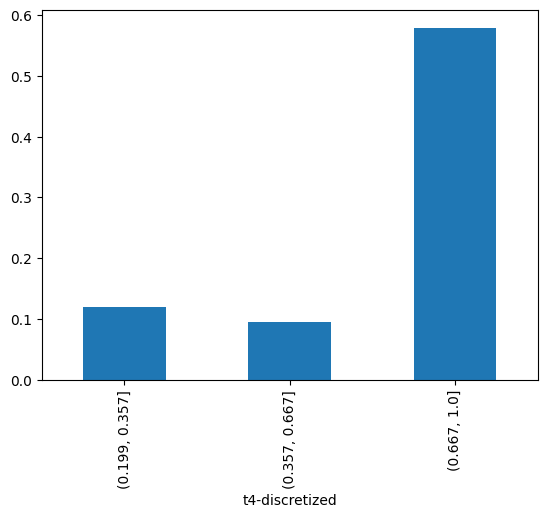

In [222]:
optimal_centroids_df \
    .query(LIMITING_QUERY) \
    .groupby('t4-discretized')['better-equal-rf'] \
    .apply(lambda x: np.sum(x)/len(x)).plot(kind='bar')


<Axes: xlabel='n2-discretized'>

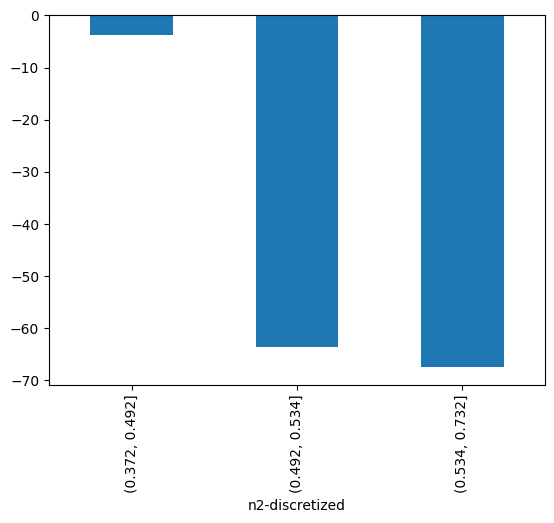

In [223]:
optimal_centroids_df \
    .query(LIMITING_QUERY) \
    .groupby('n2-discretized')['complexity-dt-difference'] \
    .apply(lambda x: np.sum(x)/len(x)).plot(kind='bar')


In [224]:
optimal_centroids_df\
    .groupby('f1-discretized')['better-dt']\
    .apply(lambda x: np.sum(x)/len(x))


f1-discretized
(0.0163, 0.47]    0.102837
(0.47, 0.648]     0.131206
(0.648, 0.964]    0.347518
Name: better-dt, dtype: float64

In [225]:
optimal_centroids_df.columns


Index(['metrics.tn_dt', 'metrics.tp_dt', 'metrics.fp_dt', 'metrics.fn_dt',
       'params.should_take_test', 'params.dataset',
       'params.data_shuffle_random_state', 'metrics.depth_dt',
       'metrics.n_leaves_dt', 'test_accuracy_dt',
       ...
       'n4-discretized', 't1-discretized', 't2-discretized', 't3-discretized',
       't4-discretized', 'clsCoef-discretized', 'hubs-discretized',
       'density-discretized', 'lsc-discretized', 'complexity-dt-difference'],
      dtype='object', length=148)

In [226]:
# import itertools
from scipy.stats import wilcoxon
# from collections import defaultdict

In [227]:
# columns = list(set(optimal_centroids_df['params.subspaces']))
# column_combinations = itertools.permutations(columns, 2)
# final_df = defaultdict(lambda: defaultdict(list))
# final_test_df = defaultdict(lambda: defaultdict(list))
# for dataset in set(optimal_centroids_df['params.dataset']):
#     for base_clf in columns:
#         final_df[dataset][base_clf] = np.mean(optimal_centroids_df.query(f"`params.subspaces` == '{base_clf}' and `params.dataset` == '{dataset}'")['test_accuracy'])
# 
#     for c1, c2 in column_combinations:
#         if final_df[dataset][c1] > final_df[dataset][c2]:
#             final_test_df[dataset][c1].append(c2)

In [228]:
optimal_centroids_df \
    .pivot_table(values=["test_accuracy", "test_accuracy_dt", "test_accuracy_rf", "diff-to-dt", "diff-to-rf"], index="params.dataset")

,diff-to-dt,diff-to-rf,test_accuracy,test_accuracy_dt,test_accuracy_rf
params.dataset,,,,,
appendicitis,0.003145,-0.053459,0.782390,0.779245,0.835849
australian,-0.022850,-0.029517,0.822367,0.845217,0.851884
bands,-0.023582,-0.094873,0.601398,0.624980,0.696271
breast,-0.080947,-0.081735,0.656608,0.737555,0.738343
bupa,-0.004596,-0.065451,0.560648,0.565244,0.626099
crx,-0.022710,-0.024843,0.840378,0.863088,0.865221
haberman,-0.102397,-0.076253,0.662309,0.764706,0.738562
heart,-0.075185,-0.123333,0.667037,0.742222,0.790370
hepatitis,-0.038333,-0.083333,0.766667,0.805000,0.850000


In [229]:
optimal_centroids_df \
    .pivot_table(
    values=["test_accuracy", "test_accuracy_dt", "test_accuracy_rf"],
    index="params.dataset")

,test_accuracy,test_accuracy_dt,test_accuracy_rf
params.dataset,,,
appendicitis,0.782390,0.779245,0.835849
australian,0.822367,0.845217,0.851884
bands,0.601398,0.624980,0.696271
breast,0.656608,0.737555,0.738343
bupa,0.560648,0.565244,0.626099
crx,0.840378,0.863088,0.865221
haberman,0.662309,0.764706,0.738562
heart,0.667037,0.742222,0.790370
hepatitis,0.766667,0.805000,0.850000
